In [1]:
import pandas as pd
import pandas_datareader
import datetime
import math
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [27]:
# 1. 准备数据
# 指定股票分析开始日期
start_date = datetime.datetime(2010, 1, 1)
# 指定股票分析截止日期
end_date = datetime.datetime(2016, 12, 30)
# 股票代码
stock_code = '600519.SS'
stock = pandas_datareader.data.DataReader(stock_code, 'yahoo', start_date, end_date)

ReadTimeout: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Read timed out. (read timeout=30)

In [18]:
print(start_date)

2010-01-01 00:00:00


In [19]:
#将数据写入文件
stock.head()
stock.to_csv("stock_train.csv")

         Date        High         Low        Open       Close     Volume  \
0  2010-01-04  129.226151  127.205109  129.226151  127.678436  5896979.0   
1  2010-01-05  128.850494  126.972198  128.467316  127.302780  4194404.0   
2  2010-01-06  127.347855  124.951164  126.964691  125.289253  5309229.0   
3  2010-01-07  125.612320  121.622841  125.289253  123.005257  6498680.0   
4  2010-01-08  123.215630  120.285500  123.215630  121.712997  4885048.0   

    Adj Close  
0  105.634399  
1  105.323608  
2  103.657715  
3  101.768059  
4  100.698906  


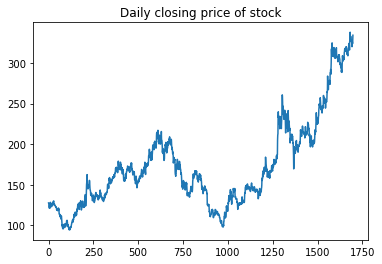

In [8]:
stock_df = pd.read_csv("stock_train.csv", index_col = 0, parse_dates=[0])
# 预览数据
print(stock_df.head())
plt.plot(stock_df['Close'])
plt.title('Daily closing price of stock')
plt.show()

In [10]:
stock_df.set_index('Date',inplace=True)
print(stock_df)

                  High         Low        Open       Close     Volume  \
Date                                                                    
2010-01-04  129.226151  127.205109  129.226151  127.678436  5896979.0   
2010-01-05  128.850494  126.972198  128.467316  127.302780  4194404.0   
2010-01-06  127.347855  124.951164  126.964691  125.289253  5309229.0   
2010-01-07  125.612320  121.622841  125.289253  123.005257  6498680.0   
2010-01-08  123.215630  120.285500  123.215630  121.712997  4885048.0   
...                ...         ...         ...         ...        ...   
2016-12-26  324.989990  316.200012  319.029999  324.480011  2600143.0   
2016-12-27  328.799988  323.500000  324.510010  326.160004  2006229.0   
2016-12-28  328.000000  323.329987  326.989990  323.720001  1787811.0   
2016-12-29  327.869995  323.000000  324.000000  327.309998  2122512.0   
2016-12-30  335.290009  326.609985  326.609985  334.149994  3468767.0   

             Adj Close  
Date                    


In [15]:
#输出数据缺失值填充之前的数据
print(stock_df.Close['20100104': '20100120'])
#数据缺失值填充及可视化
#这里以天为单位，把缺失数据填充上，这里填充的线性取值
stock_df = stock_df.resample('D').interpolate('linear')
print(stock_df.Close['20100104': '20100120'])

Series([], Name: Close, dtype: float64)


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
stock_df = stock_df[['High', 'Low', 'Open', 'Close']]
stock_df.plot(subplots = True, figsize = (10, 12))
plt.savefig('stocks_df.png')
plt.show()

In [ ]:
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize = fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = nlag, ax = ax_acf)
    plot_pacf(xt, lags = nlag, ax = ax_pacf)
    plt.tight_layout()
    return None

In [ ]:
#画出acf，pacf图像
plotds(stock_df['Close'].dropna(), nlag = 50)

In [ ]:
#平稳性检验
diff = 0
adf = ADF(stock_df['Close'])
if adf[1] > 0.05:
    print(u'原始序列经检验不平稳，p值为:%s'%(adf[1]))
else:
    print(u'原始序列经检验平稳，p值为:%s'%(adf[1]))

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox
[[lb],[p]]=acorr_ljungbox(stock_df['Close'],lags=1)
if p<0.05:
    print (u'一阶差分序列为非白噪声序列，p值为:%s'%p)
else:
    print (u'一阶差分序列为白噪声序列，p值为:%s'%p)

一阶差分序列为非白噪声序列，p值为:0.0


E:\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


                  High         Low        Open       Close
Date                                                      
2010-01-04  129.226151  127.205109  129.226151  127.678436
2010-01-05  128.850494  126.972198  128.467316  127.302780
2010-01-06  127.347855  124.951164  126.964691  125.289253
2010-01-07  125.612320  121.622841  125.289253  123.005257
2010-01-08  123.215630  120.285500  123.215630  121.712997
High     float64
Low      float64
Open     float64
Close    float64
dtype: object
Date
2010-01-04    127.678436
2010-01-05    127.302780
2010-01-06    125.289253
2010-01-07    123.005257
2010-01-08    121.712997
                 ...    
2016-12-26    324.480011
2016-12-27    326.160004
2016-12-28    323.720001
2016-12-29    327.309998
2016-12-30    334.149994
Freq: D, Name: Close, Length: 2553, dtype: float64


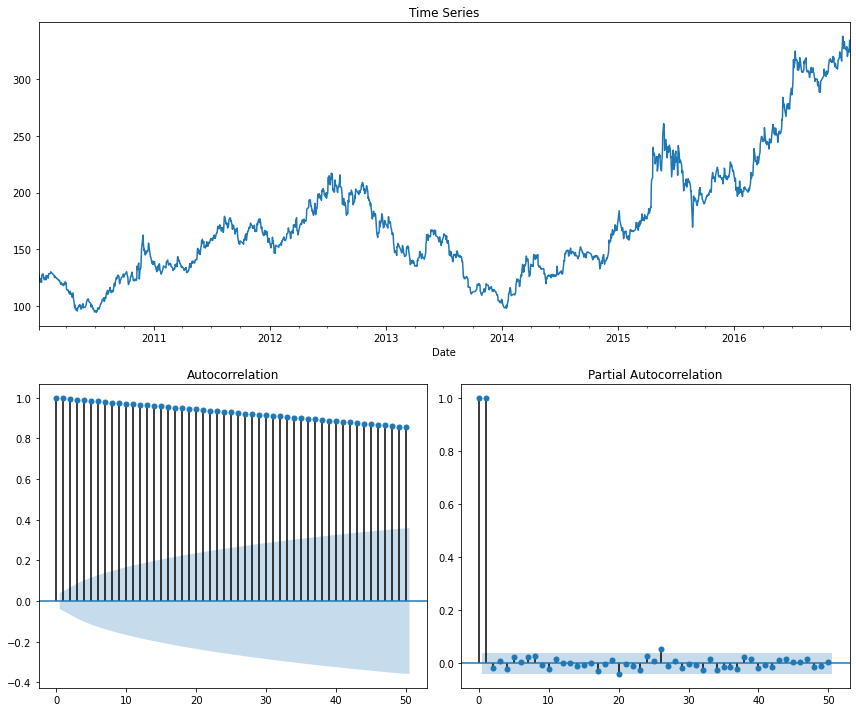

In [11]:
# 3. 处理数据，平稳化数据
# 这里只是简单第做了一节差分，还有其他平稳化时间序列的方法
# 可以查询资料后改进这里的平稳化效果
# stock_diff = stock_df.diff(1)
stock_diff = stock_df.copy()
diff = stock_diff.dropna()
print(diff.head())
print(diff.dtypes)
print(diff['Close'])
plotds(diff['Close'].dropna(), nlag = 50)

In [11]:
#平稳性检验
adf = ADF(diff['Close'])
print(diff.dtypes)
if adf[1] > 0.05:
    print(u'原始序列经检验不平稳，p值为:%s'%(adf[1]))
else:
    print(u'原始序列经检验平稳，p值为:%s'%(adf[1]))

High     float64
Low      float64
Open     float64
Close    float64
dtype: object
原始序列经检验不平稳，p值为:0.9855780932230975


In [12]:
#白噪声检验
[[lb],[p]]=acorr_ljungbox(diff['Close'],lags=1)
if p<0.05:
    print (u'一阶差分序列为非白噪声序列，p值为:%s'%p)
else:
    print (u'一阶差分序列为白噪声序列，p值为:%s'%p)

一阶差分序列为非白噪声序列，p值为:0.0


E:\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [32]:
from statsmodels.tsa.arima_model import ARIMA

In [39]:
# Optimize ARMA parameters
import statsmodels.tsa.api as smtsa

data_df=stock_diff.copy()
aicVal=[]
for ari in range(0, 10):
    for maj in range(0, 10):
        try:
            arma_obj = smtsa.ARMA(data_df.Close.tolist(), order=(ari, maj))\
            .fit(maxlag=30,method='mle', trend='nc')
            aicVal.append([ari, maj, arma_obj.aic])
        except Exception as e:
            print(e)

Estimation requires the inclusion of least one AR term, MA term, a constant or an exogenous variable.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not s

In [40]:
aicVal

[[0, 1, 30295.381738095337],
 [0, 8, 17915.920288886467],
 [0, 9, 17212.62840447141],
 [1, 0, 12067.98663897478],
 [2, 0, 12043.585448462796],
 [3, 0, 12045.58530158405],
 [4, 0, 12046.865566885586],
 [5, 0, 12042.562472318215],
 [6, 0, 12044.500035774197],
 [7, 0, 12041.815610663827],
 [8, 0, 12038.51586906139],
 [9, 0, 12039.297375145983]]

In [37]:
# 4. 根据ACF和PACF定阶并建立模型
model = ARMA(stock_df['Close'], order = (0, 1))
model_fit = model.fit(disp=0, )
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2553
Model:                     ARMA(0, 1)   Log Likelihood              -12131.073
Method:                       css-mle   S.D. of innovations             27.999
Date:                Wed, 12 May 2021   AIC                          24268.147
Time:                        11:13:32   BIC                          24285.682
Sample:                    01-04-2010   HQIC                         24274.506
                         - 12-30-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         172.7414      1.095    157.822      0.000     170.596     174.887
ma.L1.Close     0.9756      0.003    279.471      0.000       0.969       0.982
                                    Roots       

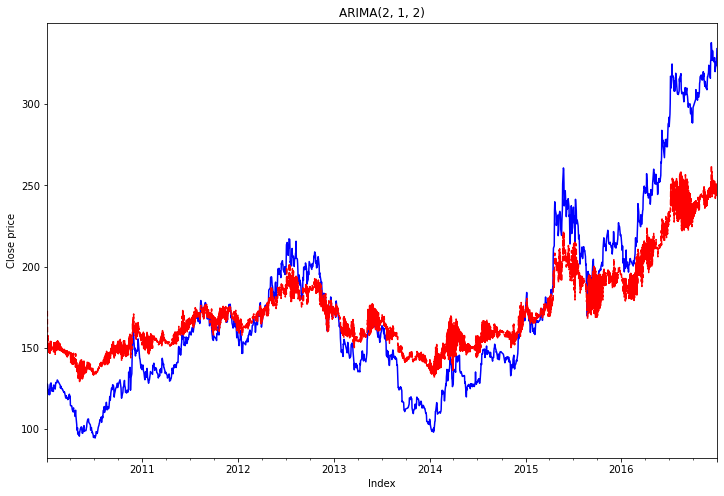

In [38]:
#模型拟合
stock_df['ARIMA'] = model_fit.predict(typ='levels')
f, axarr = plt.subplots(1, sharex = True)
f.set_size_inches(12, 8)
stock_df['Close'].plot(color = 'b', linestyle = '-', ax = axarr)
stock_df['ARIMA'].plot(color = 'r', linestyle = '--', ax = axarr)
axarr.set_title('ARIMA(2, 1, 2)')
plt.xlabel('Index')
plt.ylabel('Close price')
plt.show()

In [26]:
 #5. 预测
output = model_fit.predict('20120201', '20120207', dynamic=False, typ='levels')
print(output)

Date
2012-02-01    154.354582
2012-02-02    153.860363
2012-02-03    154.233574
2012-02-04    154.140930
2012-02-05    154.861288
2012-02-06    155.337471
2012-02-07    155.988246
Freq: D, dtype: float64


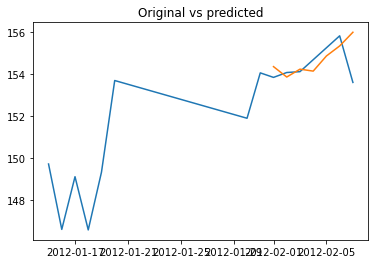

In [28]:
# 6. 可视化预测结果
#print(stock_df.Close['20110201': '20130207'])
stock_forcast = pd.concat([stock_df.Close['20120115': '20120207'], output], axis=1, keys=['original', 'predicted'])
plt.figure()
plt.plot(stock_forcast)
plt.title('Original vs predicted')
plt.savefig('./stock_pred.png', format='png')
plt.show()

In [29]:
#模型评估，平均绝对误差MAE、均方误差MSE、均方根误差RMSE 
#对短期预测结果进行评估
short_label = stock_df.Close['20120201': '20120202']
short_prediction = output[:2]
short_mse_score = mse(short_label, short_prediction)
short_rmse_score = math.sqrt(mse(short_label, short_prediction))
short_mae_score = mae(short_label, short_prediction)
print('short_MSE: %.4f, short_RMSE: %.4f, short_MAE: %.4f' % (short_mse_score, short_rmse_score, short_mae_score))

#对长期预测结果进行评估
all_label = stock_df.Close['20120201': '20120207']
all_prediction = output
long_mse_score = mse(all_label, all_prediction)
long_rmse_score = math.sqrt(mse(all_label, all_prediction))
long_mae_score = mae(all_label, all_prediction)
print('long_MSE: %.4f, long_RMSE: %.4f, long_MAE: %.4f' % (long_mse_score, long_rmse_score, long_mae_score))

short_MSE: 0.1538, short_RMSE: 0.3921, short_MAE: 0.3628
long_MSE: 0.9552, long_RMSE: 0.9773, long_MAE: 0.6630


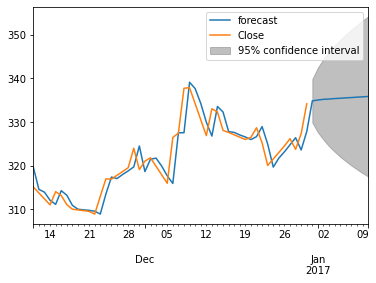

In [32]:
#对后续数据进行预测
fig = model_fit.plot_predict(len(stock_df)-50, len(stock_df)+10)
predict = model_fit.predict(start = 1, end = len(stock_df)+10, dynamic=False)
#predict[len(predict)-10:]